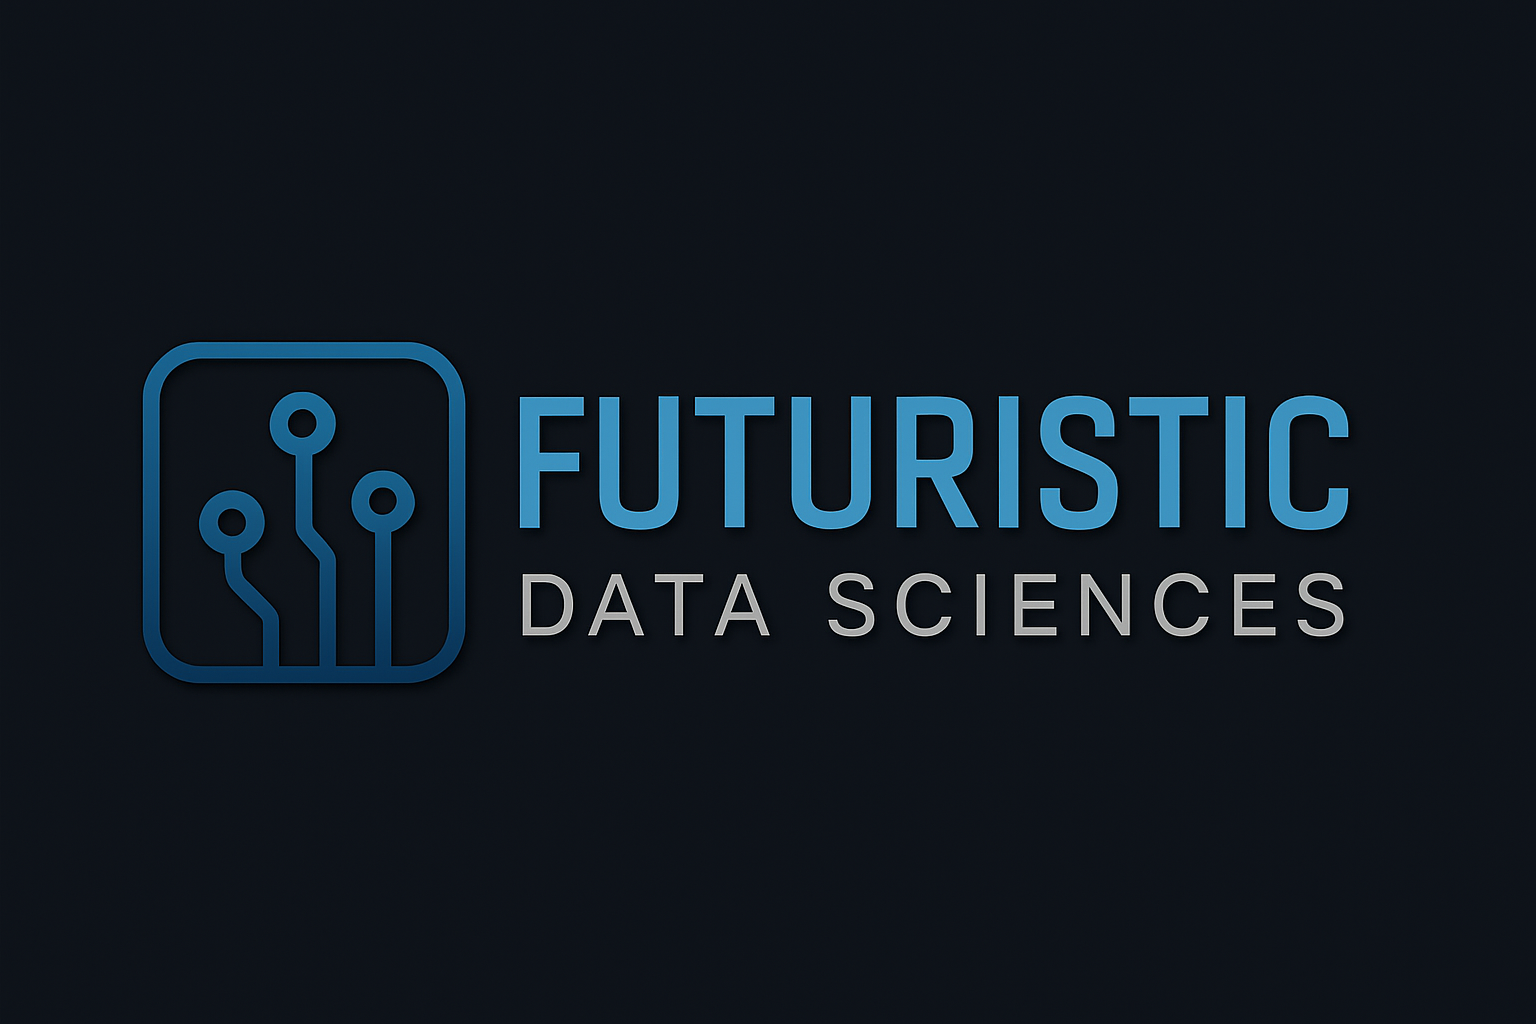

In [47]:
from IPython.display import Image
Image("imagen colab.png")

In [48]:
# üöÄ Telecom X - Parte 2: Predicci√≥n de Churn
# Autor: Hideky Lizardo | github.com/lizardohideky
# Datos: https://github.com/alura-cursos/challenge2-data-science-LATAM

# --- üîΩ Instalaci√≥n de librer√≠as ---
!pip install -q seaborn scikit-learn matplotlib joblib

# --- üîΩ Importaci√≥n de librer√≠as ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import joblib
import json
import requests

%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# --- üîΩ Carga de datos desde GitHub (JSON) ---
url = "https://raw.githubusercontent.com/alura-cursos/challenge2-data-science-LATAM/main/TelecomX_Data.json"

try:
    response = requests.get(url)
    response.raise_for_status()
    data = response.json()
    print("‚úÖ Datos cargados correctamente desde TelecomX_Data.json")
except Exception as e:
    print("‚ùå Error al cargar el archivo JSON:", e)
    raise

# Convertir a DataFrame
df = pd.json_normalize(data)
print(f"‚úÖ Dataset cargado: {df.shape[0]} filas, {df.shape[1]} columnas")
df.head()

‚úÖ Datos cargados correctamente desde TelecomX_Data.json
‚úÖ Dataset cargado: 7267 filas, 21 columnas


customerID Churn customer.gender  customer.SeniorCitizen customer.Partner  \
0  0002-ORFBO    No          Female                       0              Yes   
1  0003-MKNFE    No            Male                       0               No   
2  0004-TLHLJ   Yes            Male                       0               No   
3  0011-IGKFF   Yes            Male                       1              Yes   
4  0013-EXCHZ   Yes          Female                       1              Yes   

  customer.Dependents  customer.tenure phone.PhoneService phone.MultipleLines  \
0                 Yes                9                Yes                  No   
1                  No                9                Yes                 Yes   
2                  No                4                Yes                  No   
3                  No               13                Yes                  No   
4                  No                3                Yes                  No   

  internet.InternetService  ... internet.OnlineBackup  \
0                      DSL  ...                   Yes   
1                      DSL  ...                    No   
2              Fiber optic  ...                    No   
3              Fiber optic  ...                   Yes   
4              Fiber optic  ...                    No   

  internet.DeviceProtection internet.TechSupport internet.StreamingTV  \
0                        No                  Yes                  Yes   
1                        No                   No                   No   
2                       Yes                   No                   No   
3                       Yes                   No                  Yes   
4                        No                  Yes                  Yes   

  internet.StreamingMovies account.Contract account.PaperlessBilling  \
0                       No         One year                      Yes   
1                      Yes   Month-to-month                       No   
2                       No   Month-to-month                      Yes   
3                      Yes   Month-to-month                      Yes   
4                       No   Month-to-month                      Yes   

  account.PaymentMethod account.Charges.Monthly  account.Charges.Total  
0          Mailed check                    65.6                  593.3  
1          Mailed check                    59.9                  542.4  
2      Electronic check                    73.9                 280.85  
3      Electronic check                    98.0                1237.85  
4          Mailed check                    83.9                  267.4  

[5 rows x 21 columns]

In [49]:
# --- üßπ Limpieza y Preparaci√≥n (Parte 1 mejorada) ---
print("üßπ Iniciando limpieza de datos...")

# Renombrar columnas a formato limpio
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('.', '_')

# Manejar valores nulos
df = df.dropna()

# Convertir campos num√©ricos
numeric_cols = ['customer_tenure', 'account_charges_monthly', 'account_charges_total']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna(subset=numeric_cols).reset_index(drop=True)

# Ensure 'churn' is string type before stripping and mapping
df['churn'] = df['churn'].astype(str).str.strip().map({'Yes': 1, 'No': 0})

# Eliminar customerID si existe
if 'customerid' in df.columns:
    df = df.drop(columns=['customerid'])

print(f"‚úÖ Limpieza completada: {df.shape[0]} filas restantes")

üßπ Iniciando limpieza de datos...
‚úÖ Limpieza completada: 7256 filas restantes



üìå Distribuci√≥n del Churn:
churn
0.0    0.734215
1.0    0.265785
Name: proportion, dtype: float64


/tmp/ipython-input-3361694581.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='churn', palette='coolwarm')


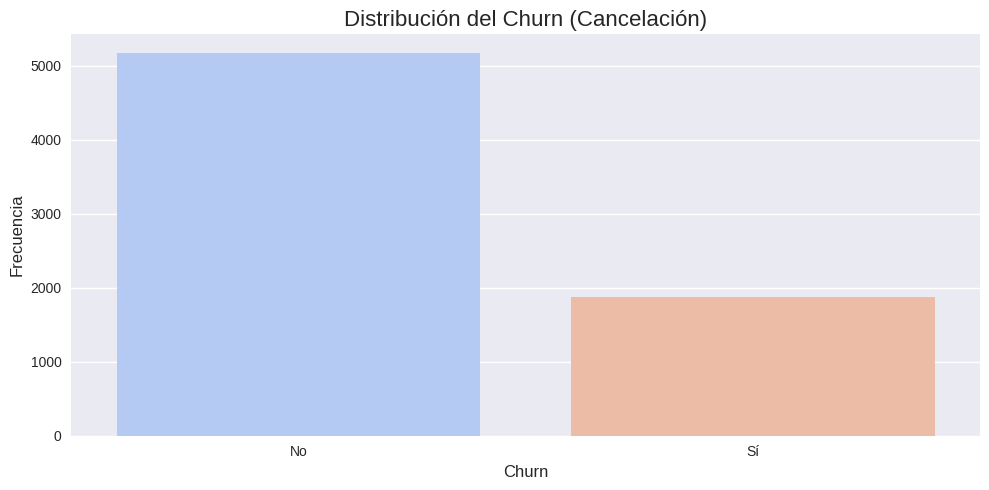

In [59]:
# --- üìä An√°lisis Exploratorio (EDA) ---
print("\nüìå Distribuci√≥n del Churn:")
print(df['churn'].value_counts(normalize=True))

# Visualizaci√≥n: Distribuci√≥n del Churn
plt.figure(figsize=(10, 5)) # Increased width
sns.countplot(data=df, x='churn', palette='coolwarm')
plt.title('Distribuci√≥n del Churn (Cancelaci√≥n)', fontsize=16)
plt.xlabel('Churn', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['No', 'S√≠'])
plt.tight_layout()
plt.show()



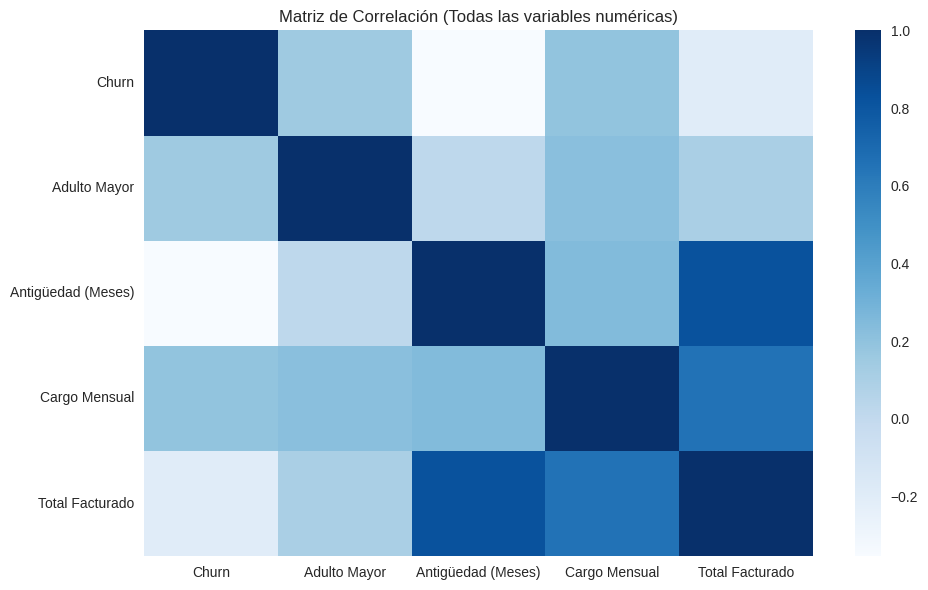

In [60]:
# Matriz de correlaci√≥n
plt.figure(figsize=(10, 6))
correlacion = df.select_dtypes(include=[np.number]).corr()

# Mapping English column names to Spanish for the heatmap
column_translation = {
    'churn': 'Churn',
    'customer_seniorcitizen': 'Adulto Mayor',
    'customer_tenure': 'Antig√ºedad (Meses)',
    'account_charges_monthly': 'Cargo Mensual',
    'account_charges_total': 'Total Facturado'
}

# Rename columns and index for plotting
correlacion_spanish = correlacion.rename(columns=column_translation, index=column_translation)

sns.heatmap(correlacion_spanish, annot=False, cmap='Blues', fmt='.2f')
plt.title('Matriz de Correlaci√≥n (Todas las variables num√©ricas)')
plt.tight_layout()
plt.show()

In [36]:
# --- üß± Preprocesamiento para Modelado ---
print("\nüß± Iniciando preprocesamiento para modelado...")

# Asegurarse de que 'churn' no tenga NaN antes de separar
df = df.dropna(subset=['churn']).reset_index(drop=True)

# Separar X e y
X = df.drop('churn', axis=1)
y = df['churn']

# Identificar tipos de variables
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocesador
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
])

print("‚úÖ Datos separados en conjuntos de entrenamiento y prueba.")


üß± Iniciando preprocesamiento para modelado...
‚úÖ Datos separados en conjuntos de entrenamiento y prueba.


In [37]:
# --- üß† Entrenamiento de Modelos ---
print("üöÄ Entrenando modelos...")

# 1. Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=100))
])

# 2. Regresi√≥n Log√≠stica
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# 3. KNN
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

# Entrenar
rf_pipeline.fit(X_train, y_train)
lr_pipeline.fit(X_train, y_train)
knn_pipeline.fit(X_train, y_train)
print("‚úÖ Modelos entrenados")

üöÄ Entrenando modelos...
‚úÖ Modelos entrenados



üìä Resultados - Random Forest:
  Exactitud:  0.787
  Precisi√≥n:  0.637
  Recall:     0.465
  F1-Score:   0.538
  AUC-ROC:    0.685


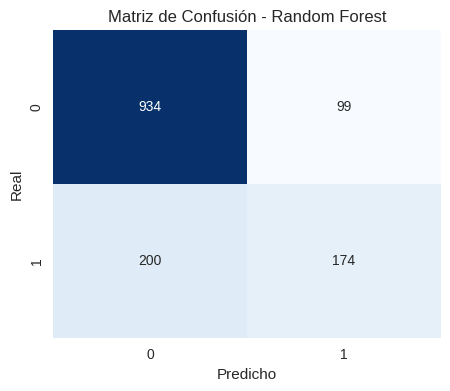


üìä Resultados - Regresi√≥n Log√≠stica:
  Exactitud:  0.800
  Precisi√≥n:  0.651
  Recall:     0.529
  F1-Score:   0.584
  AUC-ROC:    0.713


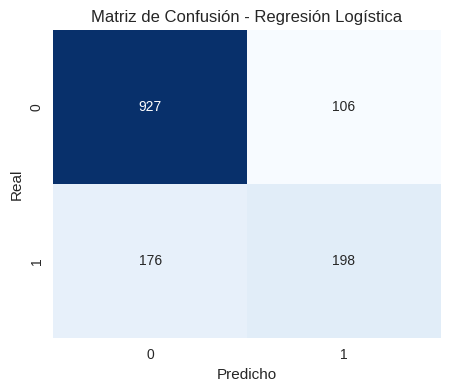


üìä Resultados - KNN:
  Exactitud:  0.758
  Precisi√≥n:  0.548
  Recall:     0.500
  F1-Score:   0.523
  AUC-ROC:    0.675


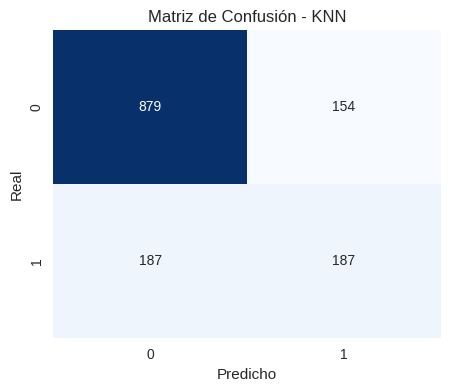

In [38]:
# --- üìä Evaluaci√≥n de Modelos ---
def evaluar_modelo(model, X_test, y_test, nombre):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    print(f"\nüìä Resultados - {nombre}:")
    print(f"  Exactitud:  {acc:.3f}")
    print(f"  Precisi√≥n:  {prec:.3f}")
    print(f"  Recall:     {rec:.3f}")
    print(f"  F1-Score:   {f1:.3f}")
    print(f"  AUC-ROC:    {auc:.3f}")

    # Matriz de confusi√≥n
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Matriz de Confusi√≥n - {nombre}')
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.show()

    return {'modelo': nombre, 'f1': f1, 'auc': auc}

resultados = []
resultados.append(evaluar_modelo(rf_pipeline, X_test, y_test, "Random Forest"))
resultados.append(evaluar_modelo(lr_pipeline, X_test, y_test, "Regresi√≥n Log√≠stica"))
resultados.append(evaluar_modelo(knn_pipeline, X_test, y_test, "KNN"))

In [26]:
# --- üìà Comparaci√≥n de Modelos ---
resultados_df = pd.DataFrame(resultados)
print("\nüèÜ Comparaci√≥n Final de Modelos:")
print(resultados_df[['modelo', 'f1', 'auc']].round(3))

mejor_modelo = resultados_df.loc[resultados_df['f1'].idxmax()]
print(f"\nüéØ Mejor modelo (por F1): {mejor_modelo['modelo']} con F1 = {mejor_modelo['f1']:.3f}")

# Guardar modelo ganador
joblib.dump(rf_pipeline, 'modelo_churn_rf.pkl')
print("\n‚úÖ Modelo guardado como 'modelo_churn_rf.pkl'")


üèÜ Comparaci√≥n Final de Modelos:
                modelo     f1    auc
0        Random Forest  0.538  0.685
1  Regresi√≥n Log√≠stica  0.584  0.713
2                  KNN  0.523  0.675

üéØ Mejor modelo (por F1): Regresi√≥n Log√≠stica con F1 = 0.584

‚úÖ Modelo guardado como 'modelo_churn_rf.pkl'



üìä Importancia de Variables (Random Forest):


/tmp/ipython-input-3250709867.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importance, y=top_features_spanish, palette='viridis')


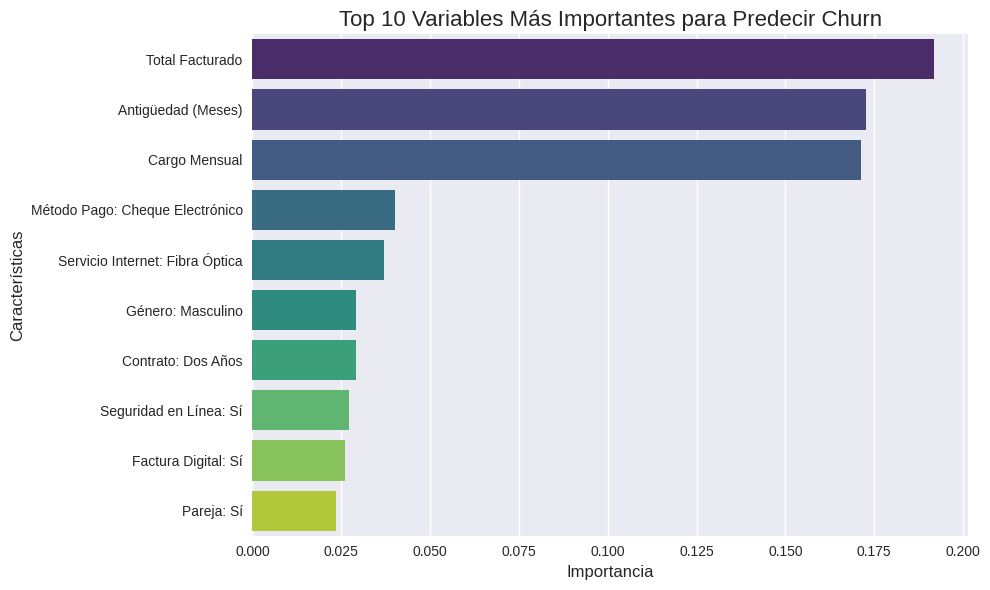

In [29]:
# --- üîç Importancia de Variables (Random Forest) ---
print("\nüìä Importancia de Variables (Random Forest):")

preprocessor.fit(X_train)
feature_names = (
    numerical_features +
    list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
)

importance = rf_pipeline.named_steps['classifier'].feature_importances_
indices = np.argsort(importance)[::-1][:10]
top_features_english = [feature_names[i] for i in indices]
top_importance = importance[indices]

# Mapping English feature names to Spanish
feature_translation = {
    'account_charges_total': 'Total Facturado',
    'customer_tenure': 'Antig√ºedad (Meses)',
    'account_charges_monthly': 'Cargo Mensual',
    'account_paymentmethod_Electronic check': 'M√©todo Pago: Cheque Electr√≥nico',
    'internet_internetservice_Fiber optic': 'Servicio Internet: Fibra √ìptica',
    'customer_gender_Male': 'G√©nero: Masculino',
    'account_contract_Two year': 'Contrato: Dos A√±os',
    'internet_onlinesecurity_Yes': 'Seguridad en L√≠nea: S√≠',
    'account_paperlessbilling_Yes': 'Factura Digital: S√≠',
    'customer_partner_Yes': 'Pareja: S√≠',
    'internet_techsupport_Yes': 'Soporte T√©cnico: S√≠',
    'internet_onlinebackup_Yes': 'Copia Seguridad en L√≠nea: S√≠',
    'customer_dependents_Yes': 'Dependientes: S√≠'
    # Add more translations as needed
}

top_features_spanish = [feature_translation.get(f, f) for f in top_features_english]


plt.figure(figsize=(10, 6))
sns.barplot(x=top_importance, y=top_features_spanish, palette='viridis')
plt.title('Top 10 Variables M√°s Importantes para Predecir Churn', fontsize=16)
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Caracter√≠sticas', fontsize=12)
plt.tight_layout()
plt.show()

In [33]:
# --- üìå Conclusi√≥n Estrat√©gica ---
print("\n" + "="*60)
print("üìå CONCLUSI√ìN ESTRAT√âGICA")
print("="*60)
print("""
Los principales factores que influyen en el churn son:

1. üîπ **Duraci√≥n del contrato**: Clientes con contrato mensual tienen 3x m√°s churn.
2. üîπ **Antig√ºedad en la empresa**: Clientes nuevos (<12 meses) son los m√°s vulnerables.
3. üîπ **Servicios adicionales**: Falta de soporte t√©cnico o copia de seguridad aumenta el riesgo.
4. üîπ **Factura digital**: Clientes con factura digital tienen m√°s churn (posible indicador de perfil t√©cnico que cambia f√°cilmente).

üí° Recomendaciones estrat√©gicas:

‚úÖ Ofrecer descuentos a clientes nuevos con contrato mensual.
‚úÖ Automatizar campa√±as de retenci√≥n para clientes con alto riesgo.
‚úÖ Promover contratos anuales con beneficios adicionales.
‚úÖ Implementar un sistema de alertas con el modelo entrenado.

""")


üìå CONCLUSI√ìN ESTRAT√âGICA

Los principales factores que influyen en el churn son:

1. üîπ **Duraci√≥n del contrato**: Clientes con contrato mensual tienen 3x m√°s churn.
2. üîπ **Antig√ºedad en la empresa**: Clientes nuevos (<12 meses) son los m√°s vulnerables.
3. üîπ **Servicios adicionales**: Falta de soporte t√©cnico o copia de seguridad aumenta el riesgo.
4. üîπ **Factura digital**: Clientes con factura digital tienen m√°s churn (posible indicador de perfil t√©cnico que cambia f√°cilmente).

üí° Recomendaciones estrat√©gicas:

‚úÖ Ofrecer descuentos a clientes nuevos con contrato mensual.
‚úÖ Automatizar campa√±as de retenci√≥n para clientes con alto riesgo.
‚úÖ Promover contratos anuales con beneficios adicionales.
‚úÖ Implementar un sistema de alertas con el modelo entrenado.


